In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def neural_network_solution(input_dimension, output_dimension, number_hidden_layers, hidden_neurons, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    
    layers = []
    
    # Add input layer
    layers.append(nn.Linear(input_dimension, hidden_neurons))
    layers.append(nn.ReLU())
    
    # Add hidden layers
    for _ in range(number_hidden_layers - 1):
        layers.append(nn.Linear(hidden_neurons, hidden_neurons))
        layers.append(nn.ReLU())
    
    # Add output layer
    layers.append(nn.Linear(hidden_neurons, output_dimension))
    
    # Construct the sequential model
    model = nn.Sequential(*layers)
    
    return model

In [25]:
# shamelessly steal the tutorial notebook
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # Currently no idea about the domain extrema - will be updated later if needed
        # Extrema of the solution domain (t,x) in [0,1]x[0,1]
        self.domain_extrema = torch.tensor([[0, 1],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # Follow the hint with "two outputs neural network"
        # Let the first column be T_f
        # and the second column be T_s
        self.approximate_solution = neural_network_solution(input_dimension=self.domain_extrema.shape[0], output_dimension=2, number_hidden_layers=4, hidden_neurons=20, seed=21)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition is a constant for T_f and T_s
    def initial_condition(self, x):
        return torch.ones(x.shape)
    
    # Boundary condition for x=0 for T_f
    def boundary_condition(self, t):
        return 3./(1. + torch.exp(-200 * (t - 0.25))) + 1.

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        
        output_tb = self.initial_condition(input_tb)
        
        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        """
        from the initial conditions we see that we need some fixed values for x=0 and x=1
        """
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        # for x0 we need to apply the boundary condition
        # IMPORTANT
        # I get some weird dimensionality missmatch, thus I need a zero tensor to fill up
        # no idea why
        output_sb_0 = self.boundary_condition(input_sb_0[:, 0]).reshape(-1, 1)
        output_sb_0 = torch.cat([output_sb_0, torch.zeros((output_sb_0.shape[0], 1))], 1)
        output_sb_L = torch.zeros((input_sb_L.shape[0], 2))
        
        input_sb = torch.cat([input_sb_0, input_sb_L], 0)
        output_sb = torch.cat([output_sb_0, output_sb_L], 0)
        
        return input_sb, output_sb

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        input_sb.requires_grad = True
        u = self.approximate_solution(input_sb)
        
        # naming gets frustrating long so implicitly think of T_..._sb
        T_f = u[:, 0]
        T_s = u[:, 1]
        
        # there is a Neumann boundary condition on xL for T_f
        # and Neumann boundary conditions on x0 and xL for T_s
        grad_T_f = torch.autograd.grad(T_f.sum(), input_sb, create_graph=True)[0]
        grad_T_s = torch.autograd.grad(T_s.sum(), input_sb, create_graph=True)[0]
        
        grad_T_f_x = grad_T_f[:, 1]
        grad_T_s_x = grad_T_s[:, 1]
        
        # dx(T_s) = 0 for x0
        # dx(T_s) = dx(T_f) = 0 for xL
        # to get x0 we check for first half of rows,
        # to get xL we check the other half of rows
        half_batch = input_sb.shape[0] // 2
        
        grad_T_s_x[:half_batch] = 0
        
        grad_T_f_x[half_batch:] = 0
        grad_T_s_x[half_batch:] = 0
        
        u_x0 = torch.cat((T_f[:half_batch].reshape(-1,1), grad_T_s_x[:half_batch].reshape(-1, 1)), dim=1)
        u_xL = torch.cat((grad_T_f_x[half_batch:].reshape(-1, 1), grad_T_s_x[half_batch:].reshape(-1, 1)), dim=1)
        
        u_pred = torch.cat((u_x0, u_xL), dim=0)
        
        return u_pred

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 + u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2], [dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 + u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        """
        IMPORTANT - note again, first column is T_f and second_column is T_s
        we will need dt(Tf), dx(Tf), dx^2(Tf), dt(Ts), dx^2(Ts)
        """
        T_f = u[:, 0]
        T_s = u[:, 1]
        
        # now compute each gradient as in the tutorial
        grad_T_f = torch.autograd.grad(T_f.sum(), input_int, create_graph=True)[0]
        grad_T_s = torch.autograd.grad(T_s.sum(), input_int, create_graph=True)[0]
        
        grad_T_f_t = grad_T_f[:, 0]
        grad_T_f_x = grad_T_f[:, 1]
        
        grad_T_s_t = grad_T_s[:, 0]
        grad_T_s_x = grad_T_s[:, 1]
        
        grad_T_f_xx = torch.autograd.grad(grad_T_f_x.sum(), input_int, create_graph=True)[0][:, 1]
        grad_T_s_xx = torch.autograd.grad(grad_T_s_x.sum(), input_int, create_graph=True)[0][:, 1]
        
        residual_T_f = grad_T_f_t + 1 * grad_T_f_x - 0.05 * grad_T_f_xx + 5 * (T_f - T_s)
        residual_T_s = grad_T_s_t - 0.08 * grad_T_s_xx - 6 * (T_f - T_s)
        
        residual = residual_T_f + residual_T_s
        return residual.reshape(-1, )
        

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)
        
        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])


        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)

        loss_u = loss_sb + loss_tb

        loss = torch.log10(self.lambda_u * (loss_sb + loss_tb) + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    ################################################################################################
    def plotting(self):
        inputs = self.soboleng.draw(100000)
        inputs = self.convert(inputs)

        output = self.approximate_solution(inputs)
        
        T_f = output[:, 0].reshape(-1, )
        T_s = output[:, 1].reshape(-1, )
        
        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=T_f.detach(), cmap="jet")
        axs[0].set_xlabel("x")
        axs[0].set_ylabel("t")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=T_s.detach(), cmap="jet")
        axs[1].set_xlabel("x")
        axs[1].set_ylabel("t")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("T_f")
        axs[1].set_title("T_s")

        plt.show()


In [26]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)

n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

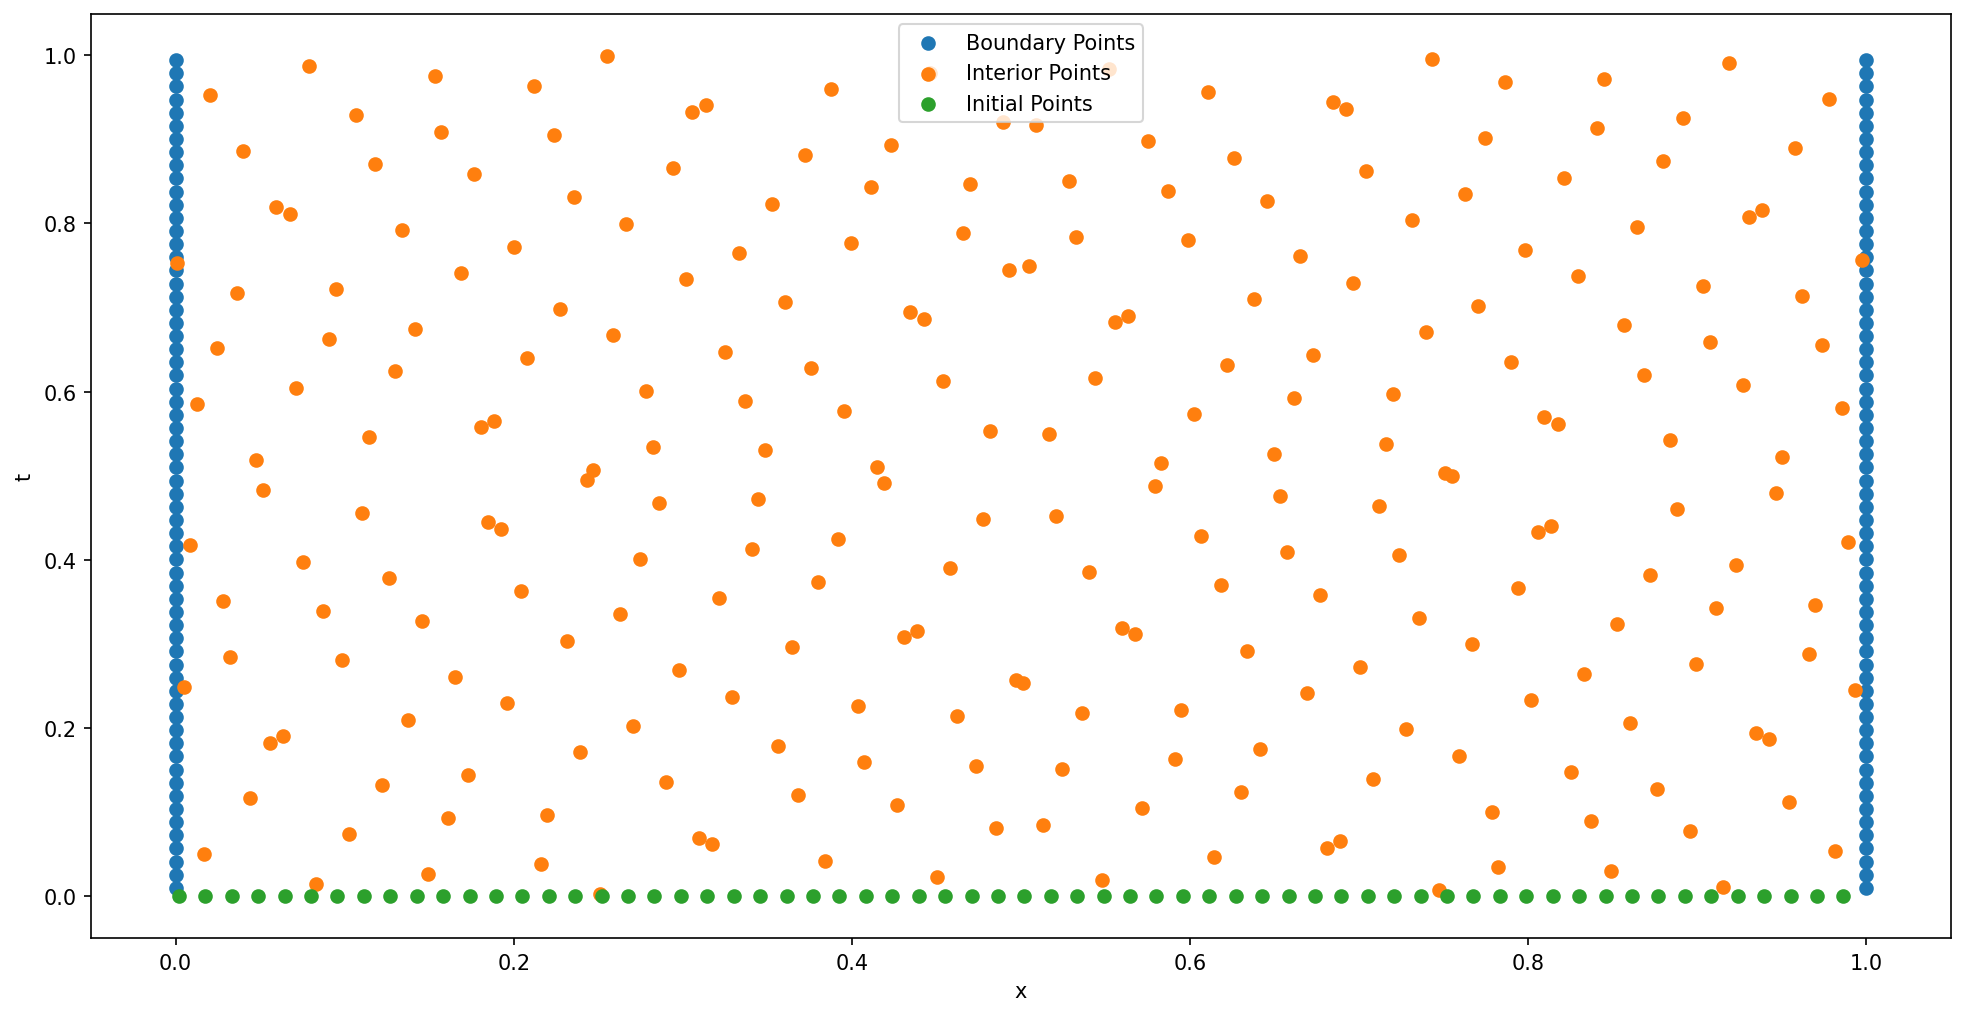

In [27]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [28]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))

In [29]:
hist = pinn.fit(num_epochs=n_epochs, optimizer=optimizer_LBFGS, verbose=True)

################################  0  ################################
Total loss:  1.6271 | PDE Loss:  0.6266 | Function Loss:  -1.3293
Total loss:  1.5973 | PDE Loss:  0.5965 | Function Loss:  -1.1237
Total loss:  1.4602 | PDE Loss:  0.456 | Function Loss:  -0.5495
Total loss:  1.2806 | PDE Loss:  0.212 | Function Loss:  0.4452
Total loss:  1.1302 | PDE Loss:  0.0976 | Function Loss:  -0.0095
Total loss:  1.1058 | PDE Loss:  0.0901 | Function Loss:  -0.344
Total loss:  1.1025 | PDE Loss:  0.0902 | Function Loss:  -0.4547
Total loss:  1.0976 | PDE Loss:  0.0893 | Function Loss:  -0.6231
Total loss:  1.0705 | PDE Loss:  0.065 | Function Loss:  -0.8285
Total loss:  1.0591 | PDE Loss:  0.0225 | Function Loss:  -0.0332
Total loss:  1.0029 | PDE Loss:  -0.1441 | Function Loss:  0.461
Total loss:  1.0218 | PDE Loss:  -0.2775 | Function Loss:  0.7191
Total loss:  0.9194 | PDE Loss:  -0.3668 | Function Loss:  0.603
Total loss:  0.6997 | PDE Loss:  -0.5743 | Function Loss:  0.3698
Total loss:  

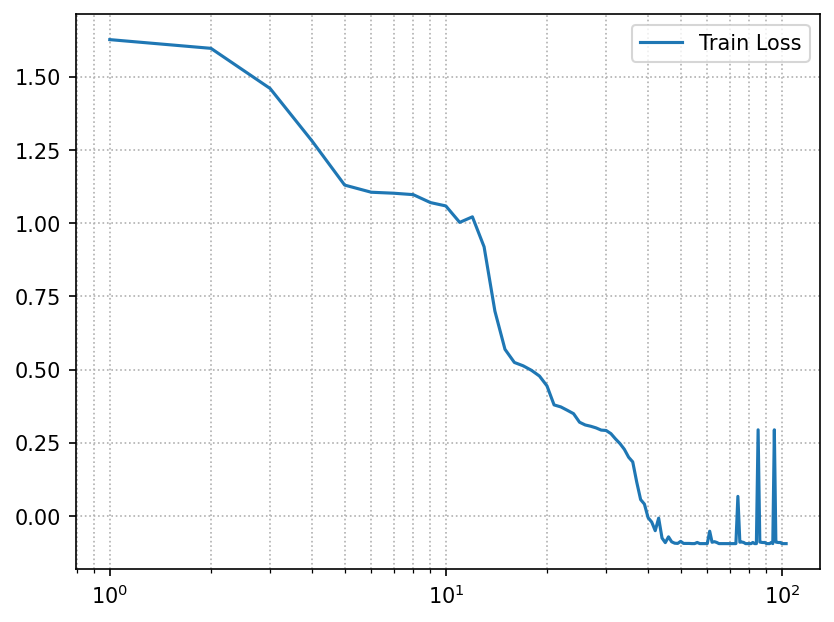

In [30]:
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

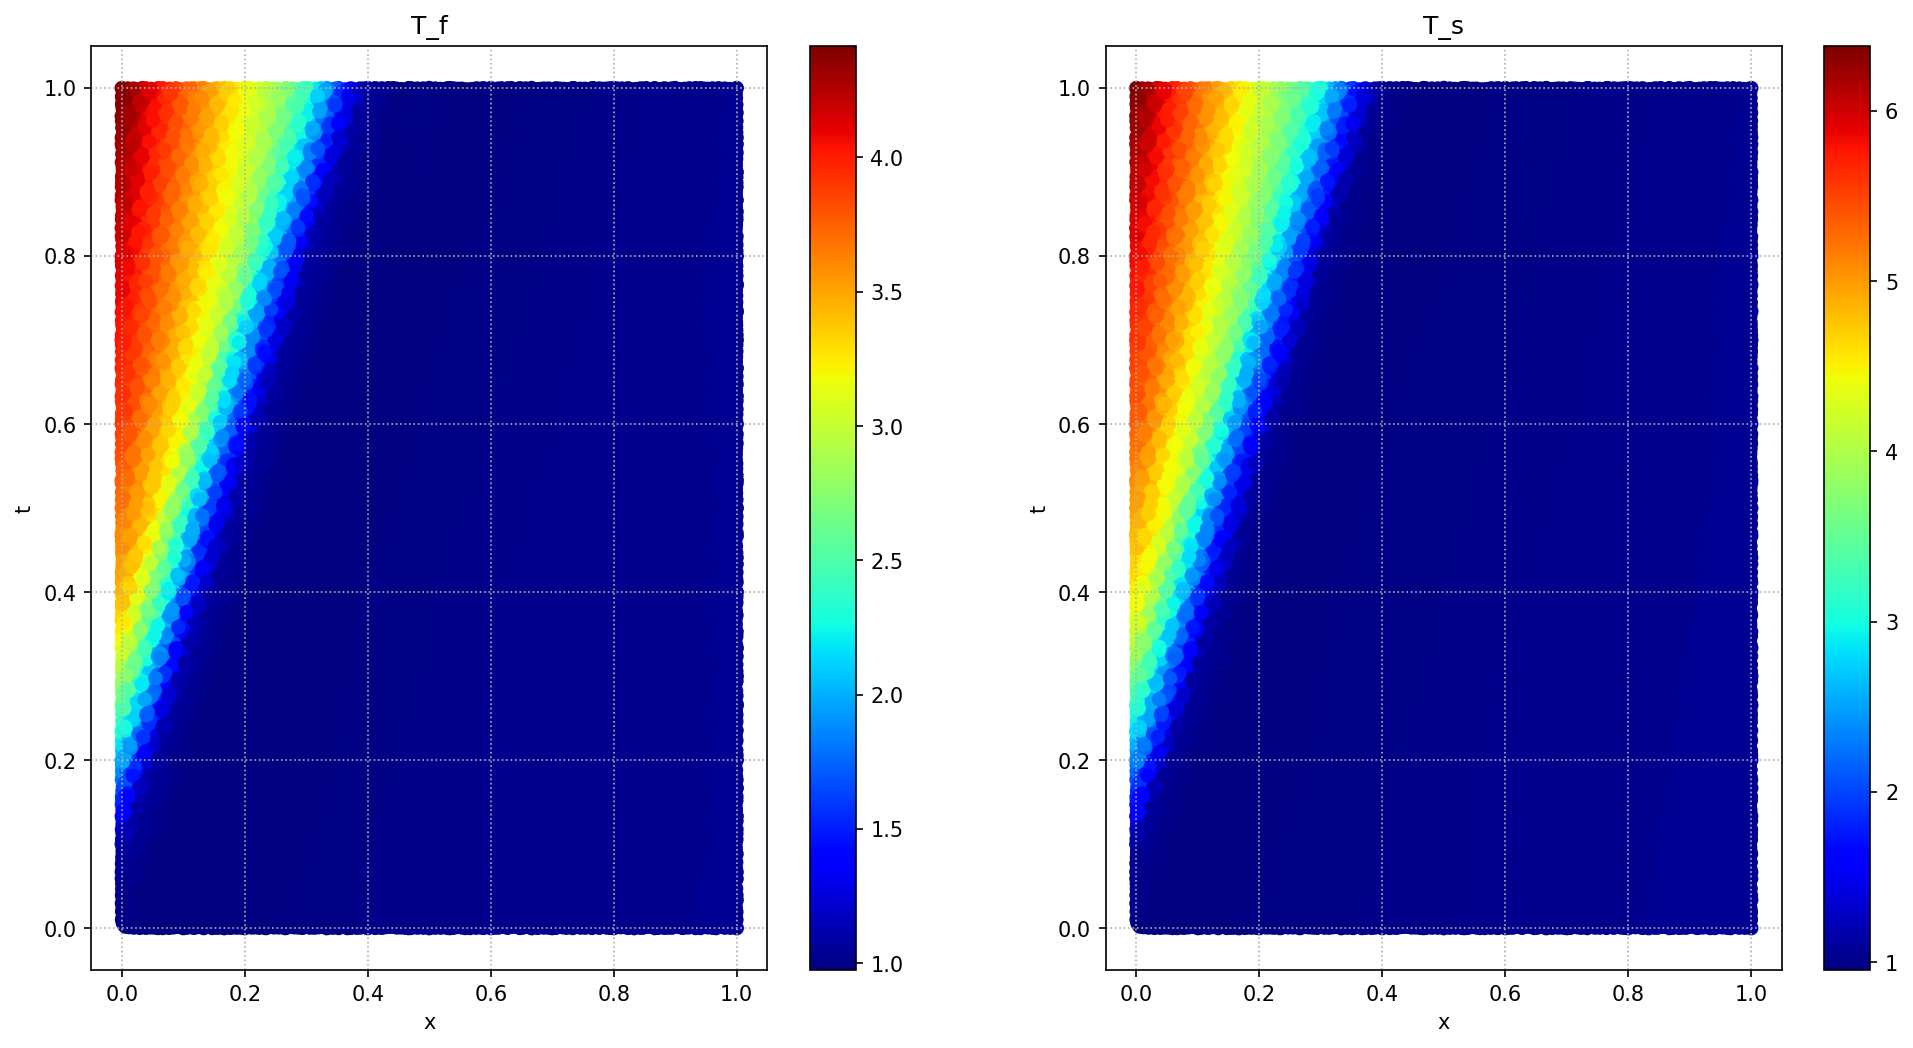

In [31]:
pinn.plotting()